# Bibliotecas

In [38]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import graphviz

# Preprocessamento

In [39]:
import os
file_features  = 'data/diva_features.pkl'
file_target  =   'data/diva_target.pkl'

if not os.path.exists(file_features):
    df = pd.read_excel('data/Dados do projeto DIVA.xlsx')

    # Ativando o novo comportamento
    pd.set_option('future.no_silent_downcasting', True)

    #substitui os valores no df
    df.replace('S',1,inplace=True)
    df.replace('N',0,inplace=True)
    df.replace('s',1,inplace=True)
    df.replace('n',0,inplace=True)
    df.replace('FEM',1,inplace=True)
    df.replace('fem',1,inplace=True)
    df.replace('MAS',0,inplace=True)
    df.replace('MASC',0,inplace=True)
    df.replace('mas',0,inplace=True)
    df.replace('masc',0,inplace=True)
    # Excluindo a coluna 'Participante'
    df = df.drop(columns=['Participante'])
    df['Altura'] = df['Altura'].str.replace(',', '.').astype(float)

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    y = df['Acesso venoso difícil']
    print(y.value_counts())
    X = df.drop(columns=['Acesso venoso difícil'])

    X.to_pickle(file_features)
    y.to_pickle(file_target)
    print(f"Arquivos {file_features} e {file_target} gerados.")


else:
    X = pd.read_pickle(file_features)
    y = pd.read_pickle(file_target)
    print(f"Arquivos {file_features} e {file_target} carregados.")

features = X.columns
X.head()

Arquivos data/diva_features.pkl e data/diva_target.pkl carregados.


,Gênero,Idade,Peso,Altura,Fez ou faz Radioterapia ?,Fez ou faz quimioterapia,Tem coagulopatia,Tem doença arterial obstrutiva periférica,Diabetes,Neropatia periférica,"Tem Hipertensão arterial, história de infarto, doença cardíaca",Sobrepeso,"Presença de queimaduras ou enxertos na região de punção, sinais de múltiplas punções",Sinais de desidratação ou hipovolemia,Mastectomizada unilateralmente,Amputação em MMSS,Flebite,Fístula Arteriovenosa
0,1,62,72,NaN,0,0,0,0,0,1,1,1,1,1,0,0,1,0
1,1,68,61,1.67,0,1,0,1,0,0,1,0,0,0,0,0,0,0
2,1,55,82,1.70,0,0,0,0,0,1,0,1,1,0,0,0,0,0
3,1,74,45,1.68,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,54,78,1.77,1,0,1,0,0,0,0,1,0,0,0,0,1,0


# Valores ausentes

In [40]:
# Contando valores ausentes em cada coluna
imputer = KNNImputer(n_neighbors=1)
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)

# Preparação para o treinamento

In [41]:
# Dados de exemplo
# X, y são seus dados de características e rótulos
# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos e parâmetros

In [42]:
# Passo 2: Definir os modelos e parâmetros
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Decision Tree Balanced': DecisionTreeClassifier(class_weight='balanced'),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
}

parameters = {
    'Decision Tree': {'clf__max_depth': [None, 2, 3, 4]},
    'Decision Tree Balanced': {'clf__max_depth': [None, 2, 3, 4]},
    'SVM': {'clf__C': [0.1, 1, 10], 'clf__gamma': [0.1, 0.01, 0.001]},
    'Logistic Regression': {'clf__C': [0.1, 1, 10]},
}


# Treinamento

In [48]:
# Passo 3: Iterar sobre os modelos e parâmetros para encontrar o melhor modelo
best_model = None
best_score = 0

for model_name, model in models.items():
    # Criando o pipeline com SMOTE e o modelo
    pipeline =  Pipeline([
        ('clf', model)
    ])

    clf = GridSearchCV(pipeline, parameters[model_name], scoring='roc_auc', cv = 10)
    clf.fit(X_train, y_train)
    
    score = clf.best_score_
    print(f"{model_name}: {score}")
   
    if score > best_score:
        best_model = clf.best_estimator_
        best_score = score

# O melhor modelo e seus parâmetros
print("Melhor modelo:", best_model)


Decision Tree: 0.6641666666666667
Decision Tree Balanced: 0.7366666666666668
SVM: 0.7283333333333334
Logistic Regression: 0.6666666666666667
Melhor modelo: Pipeline(steps=[('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=4))])


# Avaliação

In [49]:
# Faça previsões nos dados de teste
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.29      0.33      0.31         6
         1.0       0.69      0.64      0.67        14

    accuracy                           0.55        20
   macro avg       0.49      0.49      0.49        20
weighted avg       0.57      0.55      0.56        20



In [50]:
pipeline =  Pipeline([
    ('clf', DecisionTreeClassifier(class_weight='balanced'))
])

clf = GridSearchCV(pipeline, param_grid=parameters['Decision Tree Balanced'], scoring='roc_auc', cv = 10)
clf.fit(X, y)

# Extraindo a importância das variáveis do melhor modelo
best_model = clf.best_estimator_
feature_importances = best_model.named_steps['clf'].feature_importances_
decision_tree = best_model.named_steps['clf']

# Criando um DataFrame para visualizar melhor
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Ordenando por importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                                              Feature  Importance
1                                              Idade     0.406371
9                                Neropatia periférica    0.335530
2                                                Peso    0.258099
10  Tem Hipertensão arterial, história de infarto,...    0.000000
16                                            Flebite    0.000000
15                                  Amputação em MMSS    0.000000
14                     Mastectomizada unilateralmente    0.000000
13              Sinais de desidratação ou hipovolemia    0.000000
12  Presença de queimaduras ou enxertos na região ...    0.000000
11                                          Sobrepeso    0.000000
0                                              Gênero    0.000000
8                                            Diabetes    0.000000
7           Tem doença arterial obstrutiva periférica    0.000000
6                                    Tem coagulopatia    0.000000
5         

In [51]:
# Visualizar a árvore de decisão
dot_data = export_graphviz(decision_tree, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['Negativo', 'Positivo'],
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('arvore_decisao', format='png', view=True)

'arvore_decisao.png'

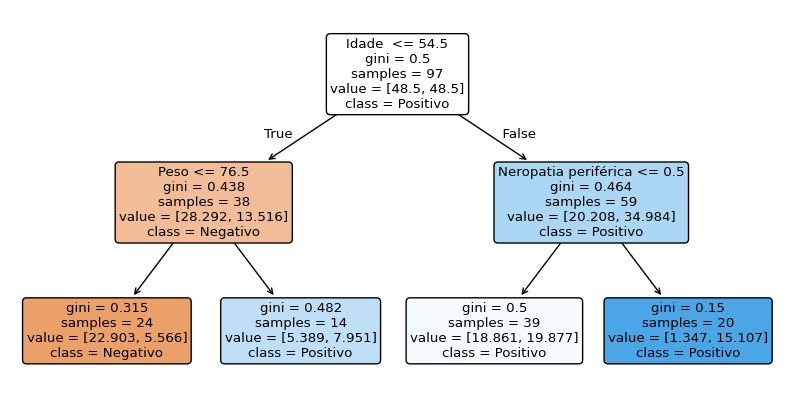

In [52]:
# Plotar a árvore usando matplotlib
plt.figure(figsize=(10,5))
a = plot_tree(decision_tree, 
              feature_names=X.columns,  
              class_names=['Negativo', 'Positivo'], 
              filled=True, 
              rounded=True)
plt.show()